In [ ]:
#default_exp image.image

In [ ]:
%load_ext autoreload
%autoreload 2

# Image classes

> Load and transform image files 

# Affine Transforms
TODO: ensure use of new pytorch transforms compatible with jit

In [ ]:
# export
from lib.data.lists import *
import torch.nn.functional as F
import math
import random
import json

#Define affine transform
class TransformMatrix:
    def __init__(self, probability): self.probability = probability
    def rotate(self,radians):    
            cos, sin = math.cos(radians), math.sin(radians)
            return torch.FloatTensor( [[cos, -sin, 0],
                                       [sin,  cos, 0],
                                       [0,      0, 1.]] )
    def shiftscale(self, x_shift=0., y_shift=0., x_scale=1., y_scale=1.):
            return torch.FloatTensor( [[x_scale, 0,       x_shift],
                                       [0,       y_scale, y_shift],
                                       [0,       0,       1.]]      )
        
    def _get(self):pass
        
    def get(self):
        if random.random() > self.probability : 
            return torch.FloatTensor( [[1., 0,  0], [0,  1., 0], [0,  0,  1.]] )
        else: 
            return self._get()     
        
#rotate around zero
class Rotation(TransformMatrix):
    def __init__(self, probability, degrees):
        super().__init__(probability)
        self.radians = math.radians(degrees)
    def _get(self): return self.rotate(np.random.uniform(-self.radians, self.radians))                
            
class ShiftScale(TransformMatrix):
    def __init__(self, probability, shift=0, scale=0.):
        super().__init__(probability)
        self.shift, self.scale = shift, scale
    def _get(self): 
        x_shift = np.random.uniform(-self.shift, self.shift)
        return self.shiftscale(np.random.uniform(-self.shift,   self.shift), 
                               np.random.uniform(-self.shift,   self.shift),
                               np.random.uniform(1.-self.scale, 1.-self.scale),
                               np.random.uniform(1.-self.scale, 1.-self.scale)
                               )                

class AffineTransforms(Transform):
    #combine affine transform in order to minimize blur. 
    #Can also randomize the order of the combination
    
    #provide the transforms as a list
    def __init__( self, transforms, shuffle=False):
        self.transforms, self.shuffle = transforms, shuffle
        
    def _getCombine(self,shuffle=False):
        if len(self.transforms) == 0:
            return None
        else:
            if self.shuffle : random.shuffle(self.transforms)
            m = self.transforms[0].get()
            for s in self.transforms[1:]:
                m = torch.matmul(m, s.get() ) 
            return m
            
    def __call__( self, tensorImage ):
        #transforms a single image
        
        #affines       = torch.empty(1, 2, 3, dtype=torch.float)
        #for aff in affines: aff[:] = self._getCombine()[:2,:]
        affines       = self._getCombine()[:2,:].unsqueeze(0)        
        align_corners = False
        tensorImage4d = tensorImage.unsqueeze(0)
        grid          = F.affine_grid(affines, tensorImage4d.size(), align_corners=align_corners )
        tfmImage      = F.grid_sample(tensorImage4d, grid, align_corners=align_corners)
        return TensorImage( tfmImage.squeeze_(0) )
    

# Other Transforms
TODO: ensure use of new pytorch transforms compatible with jit

In [ ]:
# export
import numpy as np

#Define pixel value transforms
class Image2TensorImage(Transform):
    def __call__(self, image):        
        return Image.as_tensorimage(image)
        
class TensorImage2Image(Transform):
    def __call__(self, tensorimage):        
        return Image.from_tensorimage(tensorimage)
    
# to_byte_tensor convert the image to a byte tensor 
#def numpy_to_byte_tensor(item):
#    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
#    w,h = item.size
#    return res.view(h,w,-1).permute(2,0,1)

#convert a byte tensor to float and scales to [0-1] by dividing by 255
#def byte_to_float_tensor(item): return item.float().div_(255.)
        
#def normalize(x, mean, std):
#    return (x-mean[...,None,None]) / std[...,None,None]
#def denormalize(x, mean, std):
#    return ( (x * std[...,None,None]) + mean[...,None,None])


class Numpy2Tensor(Transform):
    def __init__( self, dtype=np.float32 ): # scale, mean, std):
        self.dtype = dtype
    def __call__(self, numpyArray):        
        a = np.asarray(numpyArray)
        return torch.from_numpy( a.astype(self.dtype, copy=False) )

class NormalizeTransform(Transform):
    def __init__( self, scale, mean, std):
        self.scale = torch.as_tensor(scale)
        self.mean, self.std = torch.Tensor(mean), torch.Tensor(std)
        
    def __call__(self, tensorImage):
        ret = (tensorImage*self.scale - self.mean[...,None,None]) / self.std[...,None,None]
        return ret 
    
class DenormalizeTransform(Transform):
    def __init__( self, scale, mean, std):
        self.scale = torch.as_tensor(1./scale)
        self.mean, self.std = torch.Tensor(mean), torch.Tensor(std)
        
    def __call__(self, tensorImage):
        tensorImage = ((tensorImage * self.std[...,None,None]) + self.mean[...,None,None]).div_( self.scale)
        return tensorImage

# Image structure and show and image

In [ ]:
# export
import PIL, mimetypes

from torch import torch
import numpy as np

class TensorImage(torch.Tensor):
    @staticmethod
    def as_image(image):
        return Image(image.data.numpy().transpose(1,2,0))

class Image():
    def __init__(self, imageAsNPArray):
        self.image = imageAsNPArray
            
    def __repr__(self):
        gph = Graphics()
        gph.show_image( self )
        gph.show()
        return f"{self.image.shape}"
    
    @staticmethod
    def as_tensorimage(image, normalize=None, dtype=np.float32):
        "Convert PIL.Image or numpy.ndarray to a tensor with format: channels, width, height"
        "dtype: pytorch support: np.double, np.float16, np.int64, np.int32, and np.uint8"
        "Grayscale and RGB converts to the shape: 1, width, height and 3, width, height respectively"
        "The scale of the pixel values is left unchanged"
        "Usage 1: pil2tensor(Image.open(\"dog.47.jpg\").convert(fmt), dtype).div_(scale)"
        "         where fmt = RGB, L (=8bit for fx masks) or I (= int for fx 16 bit grayscale)"
        "         where scale = 255 for rgb, 65535 for grayscale"
        "         if your data are already at the right scale then no .div is required"
        "Usage 2: if your image is a simple rgb of grayscale the you can do. The following is slightly faster but more risky"
        "         pil2tensor(Image.open(\"dog.47.jpg\"), dtype).div_(scale) with scale as above. "
        "Usage 3: pil2tensor(Image.open(numpy_array,dtype), dtype).div_(scale) if data alredy are in a numpy array"
        a = np.asarray(image.image)
        #a = self.image
        if a.ndim==2 : a = np.expand_dims(a,2)    
        a  = np.transpose(a, (2, 0, 1))   
        a  = torch.from_numpy( a.astype(dtype, copy=False) )
        im = TensorImage( a )        
        if isinstance(normalize,Transform): im = normalize( im )
        return im

    @staticmethod
    def from_file( filename ):
        return Image( np.asarray(PIL.Image.open(filename)) )

    @staticmethod
    def from_tensorimage( tensorimage, tfm_denorm=None ):
        if isinstance(tfm_denorm,Transform): tensorimage = tfm_denorm(tensorimage)
        im = tensorimage.data.numpy().transpose(1,2,0)
        return Image( im )
    
class ImageList(FileList):
    imageExtensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

    def get(self, fn): return Image.from_file(fn)
    
    @classmethod
    def from_files(cls, path, extensions=imageExtensions, recurse=True, include=None, tfm=Transform()):
        files = FileList.get_files(path, extensions, recurse=recurse, include=include)
        return cls(files, path=path, tfm=tfm)
        

In [ ]:
# export
import matplotlib.pyplot as plt

class Graphics:
    def __init__( self, grey_cmap="gray", color_cmap=None ):
        self.grey_cmap, self.color_cmap = grey_cmap, color_cmap
        
    def show(self):
        plt.show()
        
    def show_image(self, image, ax=None, figsize=(3,3)):
        #assumes that image is either grayscale or rgb with uint8 or floats in the interval 0-1
        if ax is None: _,ax = plt.subplots(1, 1, figsize=figsize)
        ax.axis('off')
        data = image.image
        if data.dtype==np.uint8 or data.shape[-1]==1:
            ax.imshow(np.squeeze(data)/255., cmap=self.grey_cmap)
        else:
            ax.imshow(data, cmap=self.color_cmap)
            
    def show_image_batch(self, images, cols=4, rows=None, figsize=None):
        #assumes that image is either grayscale or rgb with uint8 or floats in the interval 0-1
        if rows is None: rows = int(math.ceil(len(images) / cols))
        if figsize is None: figsize=(cols*3,rows*3)
        fig,axes = plt.subplots(rows,cols, figsize=figsize)
        for xi,ax in zip(images,axes.flat): self.show_image(xi, ax, figsize=None)
            
    def show_tensorimage(self, tensorimage, ax=None, figsize=(3,3)):
        image_max = tensorimage.flatten().max().data.numpy()
        image     = TensorImage.as_image(tensorimage)
        if image_max != 0. : image.image /= image_max
        self.show_image(image, ax=ax, figsize=figsize)
            
    def show_tensorimage_batch(self, tensorimages, cols=4, rows=None, figsize=None):
        #assumes that image is either grayscale or rgb with uint8 or floats in the interval 0-1
        n = len(tensorimages)
        if rows is None: rows = int(math.ceil(n/cols))
        if figsize is None: figsize=(cols*3,rows*3)
        fig,axes = plt.subplots(rows,cols, figsize=figsize)
        for xi,ax in zip(tensorimages,axes.flat): self.show_tensorimage(xi, ax, figsize=None)            

# define image dataset

In [ ]:
# export
from lib.data.external import *
  
class ImageDataset(torch.utils.data.Dataset):
    #x, y significes input vs output
    #def __init__(self, config, files, input_transform=None, output_transform=None ): 
    def __init__(self, config, files, targets=None, input_transform=None, output_transform=None ): 
        self.config, self.files, self.targets = config, files, targets
        self.input_transform, self.output_transform = input_transform, output_transform

    def __len__(self): return len(self.files)
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (xt, yt, index) where xt is a tensor, yt a number, 
                                   index is the index of xt and yt in the dataset 
        """
        if self.targets is None : 
            self.initializeTarget()
        
        #data_t, target_t = self.files[index], self.targets[index]
        data_t = self.files[index]
        target_t = self.targets[index]
        
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        #img = Image.fromarray(img.numpy(), mode='L')
        if self.input_transform is not None:
            data_t = self.input_transform(data_t)

        if self.output_transform is not None:
            target_t = self.output_transform(target_t)

#        return data_t, target_t, index
        return data_t, target_t
     
    def initializeTarget(self):
        self.targets = self.files.label_by_func( self.config.label_from_path() )
    
    def dataloader(self, batch_size:int, shuffle:bool, num_workers:int=0):
        return torch.utils.data.DataLoader(self, batch_size=batch_size, shuffle=shuffle,
                                           num_workers=num_workers)
    
    def split2train_test(self):
        ix_all = np.arange(len(self), dtype=int)
        random.randint
        
        ibx_train = self.files.label_by_func( self.config.is_training_from_path() )
        train_files, test_files = ImageDataset.split2ways(ImageList, self.files, ibx_train)        
        if self.targets is None:
            train_targets, test_targets = None, None
        else:   
            train_targets, test_targets = ImageDataset.split2ways(list, self.targets, ibx_train)
            
        ds_train = ImageDataset(config=self.config, files=train_files, targets=train_targets, \
                                input_transform=self.input_transform, output_transform=self.output_transform)
        
        ds_test  = ImageDataset(config=self.config, files=test_files, targets=test_targets, \
                                input_transform=self.input_transform, output_transform=self.output_transform)
        return ds_train, ds_test
    
    @staticmethod
    def split2ways(cls,items,selector):
        true_list  = [i for i,s in zip(items,selector) if s]
        false_list = [i for i,s in zip(items,selector) if not s]
        #return self.new(true_list), self.new(false_list)
        return cls(true_list), cls(false_list)


In [ ]:
# export
import collections
from collections import defaultdict

class Vocab():
    "Contain the correspondence between numbers and tokens and numericalize."
    #categories are created on the fly
    #it start by containing 0 categories. 
    #adds a categories when it is asked to process (or process1) unknown categories 
    def __init__(self):
        self.stoi = collections.defaultdict(int)
    
    def __len__(self): return len(self.stoi)
    
    def process(self, items): 
        for i,item in enumerate(items):
            if item not in self.stoi: self.stoi[item] = len(self.stoi)
        return [self.stoi[o] for o in items]
    
    def process1(self, item):  
        if item not in self.stoi: self.stoi[item] = len(self.stoi)
        return self.stoi[item]


In [ ]:
# hide

tokens = ["en","to","tr", "hundred"] 
tokens2 = ["to","tr", "hundred", "en"] 
vocab = Vocab()
print(vocab.process(tokens))
print(vocab.process(tokens2))


[0, 1, 2, 3]
[1, 2, 3, 0]


In [ ]:
# export
from lib.data.external import *
    
class DatasetConfiguration():
    url:str
    channels_in:int
    channels_out:int
    scale:float
    mean:list
    std:list
    
    def initialize(self): return self
        
    #return an function that takes a path as argument and returns :
    #True if the file i is to be used for training othewise False
    def is_training_from_path(self): pass
    
    #return an function that tkes a path as arggument and returns a number that    
    #represents a label
    def label_from_path(self): pass

    def dataset(self, input_transform ): pass
    
class IMAGENETTE_160_Configuration(DatasetConfiguration):
    url:str = URLs.IMAGENETTE_160
    channels_in:int = 3
    channels_out:int = -1 #10
    scale:float = 1./255
    mean:list = [0.485, 0.456, 0.406]
    std:list = [0.229, 0.224, 0.225] 
    files:list = None
    target:list = None
    categories:Vocab = Vocab()
        
    def initialize(self): 
        #The numbers are treated like categories (one hot encoding) by the nn
        #We initalize the categories so that the numbers are in order
        self.files  = ImageList.from_files( untar_data(self.url) )
        #self.target = [path.parent.name for path in self.files]        
        #self.target = self.categories.process(self.target)
        
        #self.target = [path.parent.name for path in self.files]        
        self.targets = self.files.label_by_func( self.label_from_path() )
        self.channels_out = len(self.categories)
        return self
    
    def is_training_from_path(self): 
        def f(path): return path.parent.parent.name=="train"
        return f
    def label_from_path(self): 
        def f(path): return self.categories.process1(path.parent.name)
        return f
    
    def dataset(self, input_transform ):
        return ImageDataset(self, self.files, self.targets, input_transform=input_transform, output_transform=output_transform )
    
class MNIST_Configuration(DatasetConfiguration):
    url:str = URLs.MNIST
    channels_in:int = 1
    channels_out:int = -1 #10
        
    scale:float = 1./255
    mean:list = [0.1307]
    std:list = [0.3081] 
    categories:Vocab = Vocab()
    
    def initialize(self): 
        #the numbers are treated like categories (one hot encoding) by the nn
        #Initialize the categories so that the numbers are in order
        self.categories.process(["0","1","2","3","4","5","6","7","8","9"])
        self.channels_out = len(self.categories)
        self.files  = ImageList.from_files( untar_data(self.url) )
        
        self.targets = self.files.label_by_func( self.label_from_path() )
        return self
    
    def is_training_from_path(self): 
        def f(path): return path.parent.parent.name=="training"
        return f
    def label_from_path(self): 
        def f(path): return self.categories.process1(path.parent.name)
        return f
    
    def dataset(self, input_transform, output_transform ):
        return ImageDataset(self, self.files, self.targets, input_transform=input_transform, output_transform=output_transform )
        #return ImageDataset(config=self, files=self.files, input_transform=input_transform )

class MNIST_TINY_Configuration(MNIST_Configuration):
    url:str = URLs.MNIST_TINY
        
    def is_training_from_path(self): 
        def f(path): return path.parent.parent.name=="train"
        return f


# Tests

In [ ]:
config1  = IMAGENETTE_160_Configuration().initialize()
print(config1.mean)

config2  = MNIST_Configuration().initialize()
print( config2.mean )

[0.485, 0.456, 0.406]
[0.1307]


In [ ]:
from lib.data.lists import *

class ResizeFixed(Transform):
    def __init__(self, size, resize_tfm:int=PIL.Image.BILINEAR):
        if isinstance(size,int): size =(size,size)
        self.size = size
        self.resize_tfm = resize_tfm

    def __call__(self, item): return item.image.resize(self.size, self.resize_tfm)

#config  = IMAGENETTE_160_Configuration().initialize()
config   = MNIST_TINY_Configuration().initialize()
#config   = MNIST_Configuration().initialize()

#ds       = config.dataset(input_transform = Transforms([GeneralCrop( size(14,14),Image2TensorImage()] )
input_transform = Transforms([Image2TensorImage()])
#input_transform = Image2TensorImage()
ds       = config.dataset(input_transform = input_transform, output_transform=Numpy2Tensor(dtype=int)  )
ds_train, ds_test = ds.split2train_test()

#print(f"ds_train:{ds_train} ds_test:{ds_test}")

print(f"ds_train:{len(ds_train.files)} ds_test:{len(ds_test.files)}")
#dl_train, dl_test = ds_train.dataloader(128,True), ds_test.dataloader(512, False)
dl_train, dl_test = ds_train.dataloader(32,True), ds_test.dataloader(64, False)
databunch = DataBunch(dl_train, dl_test, config.channels_in, config.channels_out)

len(ds), len(ds_train), len(ds_test),len(dl_train), len(dl_test), config.channels_out

ds_train:709 ds_test:719


(1428, 709, 719, 23, 12, 10)

In [ ]:

#rf = ResizeFixed((28,28))
#config.files[0], rf(config.files[0]) 

tensor([7, 3, 7, 3, 7, 7, 3, 7, 7, 3, 7, 7, 3, 3, 3, 3, 7, 7, 7, 7, 7, 7, 3, 7,
        3, 7, 3, 3, 3, 3, 3, 3])


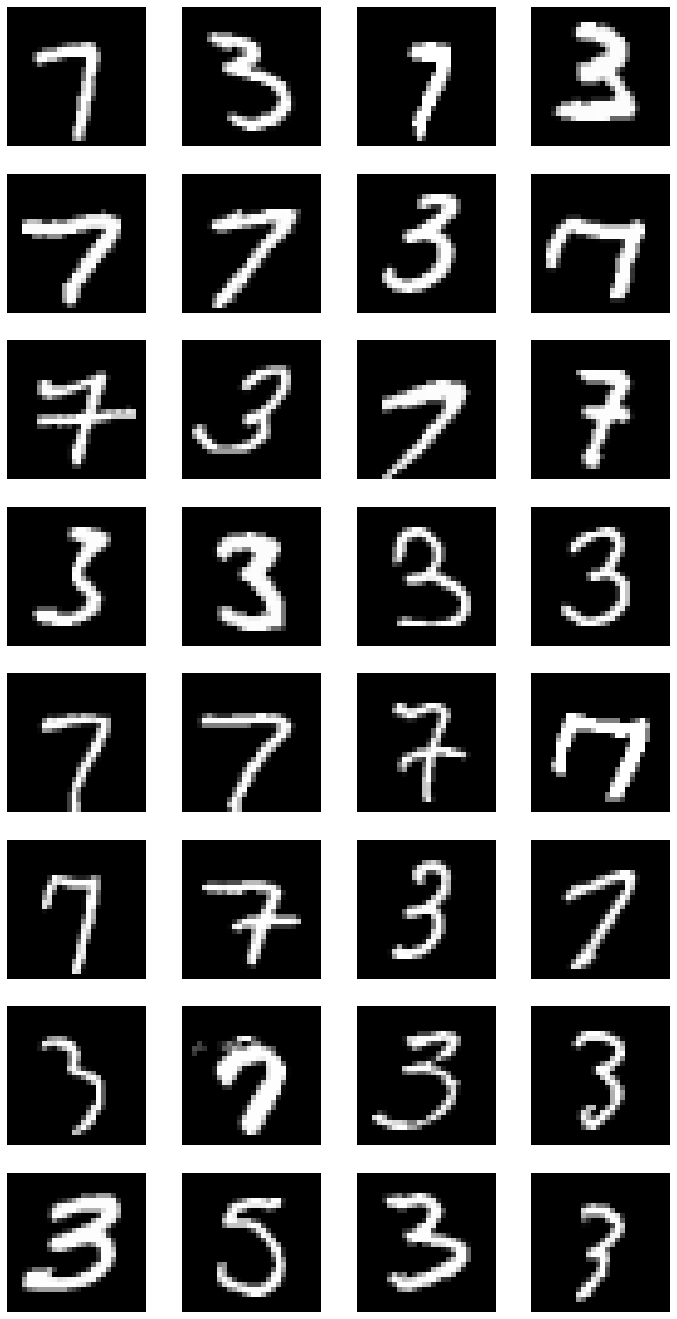

In [ ]:
x = next(iter(dl_train))
Graphics().show_tensorimage_batch( x[0] ) #[0] to get the images, the labels in x[1]
#
print(x[1])

number of files: 13394


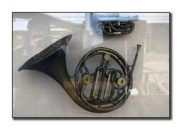

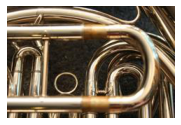

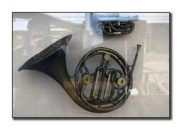

(160, 231, 3)

In [ ]:
# test that we can load mnist or imagenette files
from lib.data.external import *
path, scale, mean, std  = untar_data(URLs.IMAGENETTE_160), \
                            1./255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    
files = ImageList.from_files( path )
print( f"number of files: {len(files)}" )

gph = Graphics()
gph.show_image( files[0] )
gph.show()
gph.show_image( files[1] )
files[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


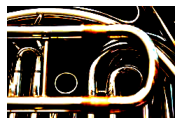

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


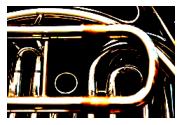

In [ ]:
# test that the tranformations works
t_image     = Image.as_tensorimage(files[1], NormalizeTransform(scale, mean, std) )
#affines     = AffineTransforms([Rotation(.3,30), ShiftScale(.3,shift=0.5,scale=0.25)])
affines     = AffineTransforms([Rotation(.3,30)
                               ])
t_image_tfm = affines(t_image)

gph = Graphics()
gph.show_image(Image.from_tensorimage(t_image))
gph.show()
gph.show_image(Image.from_tensorimage(t_image_tfm))

#img         = Image.from_tensorimage(tsi_img_tfm, DenormalizeTransform(1., mean, std))
#tfms     = [make_rgb, CenterCrop(128,scale=2), to_byte_tensor, to_float_tensor]
#inputTfm = Transforms([Image2TensorImage(), NormalizeTransform(config.scale, config.mean, config.std)])


# Export scripts

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 00_test.ipynb.
Converted 01_data.external.ipynb.
Converted 02_lists.ipynb.
Converted 03_images.ipynb.
Converted 05_Learner.ipynb.
Converted 05_model.ipynb.
Converted 06_modelmanger.ipynb.
Converted 07_optimizers.ipynb.
Converted app_image_01_imagenette_optimizers.ipynb.
Converted app_image_01_mnist_optimizers.ipynb.
Converted index.ipynb.
